In [12]:
using Pkg, Random
using Laplacians, LinearAlgebra, StatsBase, SparseArrays
using Plots, ProgressMeter

In [13]:
Random.seed!(111)
gr()

Plots.GRBackend()

In [14]:
println("Julia version: $VERSION")
Lap_ver = Pkg.installed()["Laplacians"]
println("Laplacians.jl version: $Lap_ver")

Julia version: 1.1.0
Laplacians.jl version: 1.1.0


In [15]:
function spgraph(n, sparsity)
    g = spzeros(n, n)
    for i in 1:n
        for j in i:n
            if rand() <= sparsity
                g[i, j] = 1
            end
        end
    end
    g[diagind(g)] .= 0
    g = g + g'
    return g
end

spgraph (generic function with 1 method)

In [16]:
function benchmark_lap(graph_sizes, sparsity; tol=1e-6, verbose=false, n_runs=5)
    Results = Dict()

    @showprogress for n in graph_sizes
        A = spgraph(n, sparsity)
        L = lap(A)
        b = randn(n); b .-= mean(b)

        for lapsolver in LapSolvers
            if verbose println("Solver ", lapsolver) end

            sname = nameof(lapsolver)
            if !haskey(Results, sname)
                Results[sname] = Dict("build_time" => [],
                                      "solve_time" => [],
                                     "build_alloc" => [],
                                     "solve_alloc" => [])
            end

            # Take the average over a couple runs
            bt = bb = st = sb = 0
            for i in 1:n_runs
                solve, t, bytes, _, _ = @timed lapsolver(A, tol=tol, verbose=verbose)
                bt += (t/n_runs)
                bb += (bytes/n_runs)

                x, t, bytes, _, _ = @timed solve(b)
                st += (t/n_runs)
                sb += (bytes/n_runs)

                if verbose
                    println("Relative norm: ", norm(L * x - b) / norm(b), "\n")
                end
            

            end
            push!(Results[sname]["build_time"], bt)
            push!(Results[sname]["build_alloc"], bb/1e6)
            push!(Results[sname]["solve_time"], st)
            push!(Results[sname]["solve_alloc"], sb/1e6)

        end
    end

    # Plot results for all solvers, varying graph size
    labels = []
    build_times = []; build_allocs = []; solve_times = []; solve_allocs = []

    for (solver, result) in Results
        push!(labels, solver)
        push!(build_times, result["build_time"])
        push!(build_allocs, result["build_alloc"])
        push!(solve_times, result["solve_time"])
        push!(solve_allocs, result["solve_alloc"])
    end

    p1 = plot(graph_sizes, build_times, labels=labels, legend=:topleft, title="build_times", xaxis="n vertices", yaxis="seconds")
    p2 = plot(graph_sizes, build_allocs, labels=labels, legend=:topleft,  title="build_allocations", xaxis="n vertices", yaxis="MB")
    p3 = plot(graph_sizes, solve_times, labels=labels, legend=:topleft, title="solve_times", xaxis="n vertices", yaxis="seconds")
    p4 = plot(graph_sizes, solve_allocs, labels=labels, legend=:topleft,  title="solve_allocations", xaxis="n vertices", yaxis="MB")

    plot(p1, p2, p3, p4, layout=(2,2), size=(900, 600))
end

benchmark_lap (generic function with 1 method)

### Laplacian solver, dense matrices (70% non-zeros)

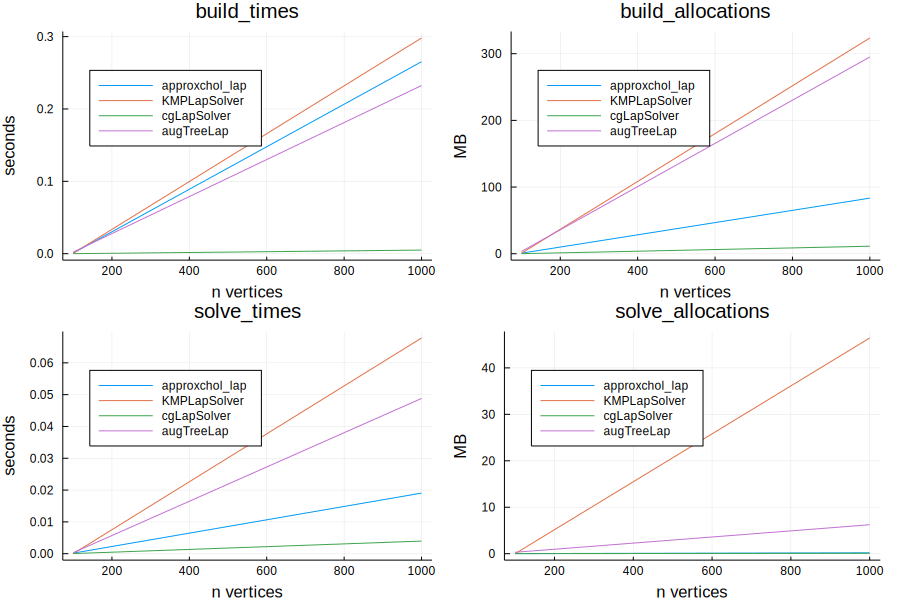

In [17]:
graph_sizes = Array{Int64}([1e2, 1e3])#, 1e4])
benchmark_lap(graph_sizes, 0.7)

### Laplacian solver, sparse matrices (10% non-zeros)

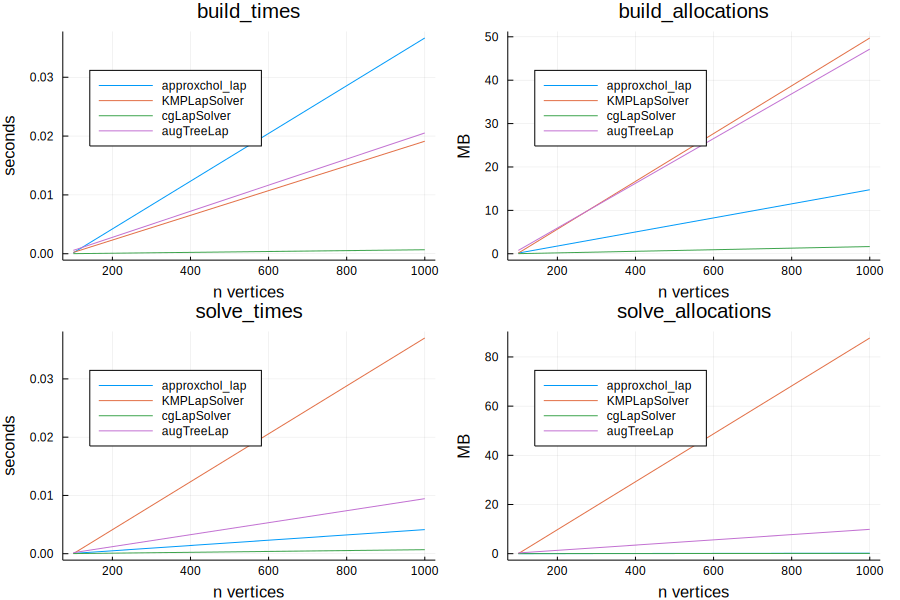

In [18]:
benchmark_lap(graph_sizes, 0.1)

### Laplacian solver, very sparse (1% non-zeros)

In [19]:
benchmark_lap(graph_sizes, 0.01)

MethodError: MethodError: no method matching setindex_shape_check(::Float64, ::Int64)
Closest candidates are:
  setindex_shape_check(!Matched::AbstractArray{#s72,1} where #s72, ::Integer) at indices.jl:218
  setindex_shape_check(!Matched::AbstractArray{#s72,1} where #s72, ::Integer, !Matched::Integer) at indices.jl:221
  setindex_shape_check(!Matched::AbstractArray{#s72,2} where #s72, ::Integer, !Matched::Integer) at indices.jl:225
  ...

In [20]:
function benchmark_sddm(matrix_sizes, sparsity; tol=1e-6, verbose=false)
    Results = Dict()

    @showprogress for n in matrix_sizes
        A = spgraph(n, sparsity)
        L = lap(A)
        dval = zeros(n); dval[1] = dval[n] = 1e-3;
        SDDM = L + spdiagm(0=>dval)
        b = randn(n); b .-= mean(b)

        for sddmsolver in [augTreeSddm, KMPSDDMSolver, approxchol_sddm]
            if verbose println("Solver ", sddmsolver) end

            sname = nameof(sddmsolver)
            if !haskey(Results, sname)
                Results[sname] = Dict("build_time" => [],
                                      "solve_time" => [],
                                     "build_alloc" => [],
                                     "solve_alloc" => [])
            end

            # Take the average over a couple runs 
            n_runs = 5
            bt = bb = st = sb = 0
            for i in 1:n_runs
                solve, t, bytes, _, _ = @timed sddmsolver(SDDM, tol=tol, verbose=verbose)
                bt += (t/n_runs)
                bb += (bytes/n_runs)

                x, t, bytes, _, _ = @timed solve(b)
                st += (t/n_runs)
                sb += (bytes/n_runs)

                if verbose
                    println("Relative norm: ", norm(SDDM * x - b) / norm(b), "\n")
                end
            
            end
            push!(Results[sname]["build_time"], bt)
            push!(Results[sname]["build_alloc"], bb/1e6)
            push!(Results[sname]["solve_time"], st)
            push!(Results[sname]["solve_alloc"], sb/1e6)

        end
    end

    # Plot results for all solvers, varying graph size
    labels = []
    build_times = []; build_allocs = []; solve_times = []; solve_allocs = []

    for (solver, result) in Results
        sname = if (string(solver) == "#155") "approxchol_sddm" else solver end
        push!(labels, sname)
        push!(build_times, result["build_time"])
        push!(build_allocs, result["build_alloc"])
        push!(solve_times, result["solve_time"])
        push!(solve_allocs, result["solve_alloc"])
    end

    p1 = plot(matrix_sizes, build_times, labels=labels, legend=:topleft, title="build_times", xaxis="n vertices", yaxis="seconds")
    p2 = plot(matrix_sizes, build_allocs, labels=labels, legend=:topleft,  title="build_allocations", xaxis="n vertices", yaxis="MB")
    p3 = plot(matrix_sizes, solve_times, labels=labels, legend=:topleft, title="solve_times", xaxis="n vertices", yaxis="seconds")
    p4 = plot(matrix_sizes, solve_allocs, labels=labels, legend=:topleft,  title="solve_allocations", xaxis="n vertices", yaxis="MB")

    plot(p1, p2, p3, p4, layout=(2,2), size=(900, 600))
end

benchmark_sddm (generic function with 1 method)

### SDDM solver, dense matrices (70% non-zeros)

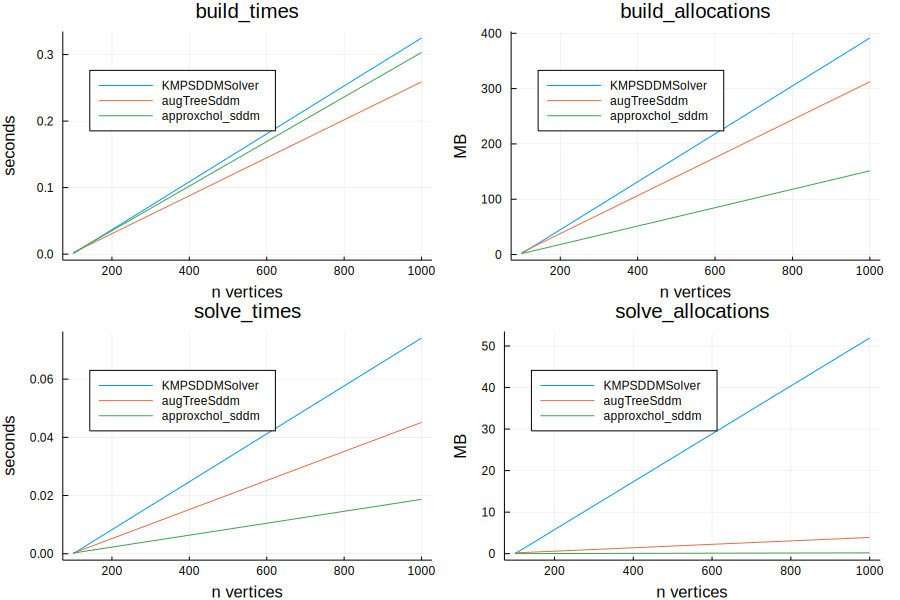

In [21]:
matrix_sizes = Array{Int64}([1e2, 1e3])#, 1e4])
benchmark_sddm(matrix_sizes, 0.7)

### SDDM solver, sparse matrices (10% non-zeros)

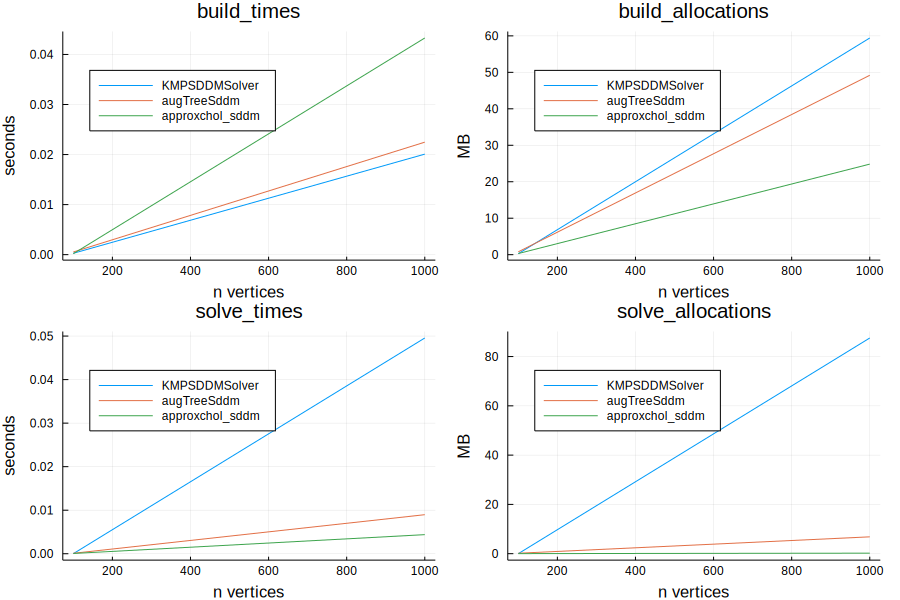

In [22]:
benchmark_sddm(matrix_sizes, 0.1)